[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanfobel/gridwatch-history/main)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, ".")
sys.path.insert(0, "..")

# Plotting preferences
from cycler import cycler
from matplotlib import rcParams

%matplotlib inline

LIGHT_COLORMAP = [
    (0.533, 0.741, 0.902),
    (0.984, 0.698, 0.345),
    (0.565, 0.804, 0.592),
    (0.965, 0.667, 0.788),
    (0.749, 0.647, 0.329),
    (0.737, 0.6, 0.78),
    (0.929, 0.867, 0.275),
    (0.941, 0.494, 0.431),
    (0.549, 0.549, 0.549),
]

# Plotting preferences
plt.rc("axes", prop_cycle=cycler("color", LIGHT_COLORMAP))
plt.rc("figure", figsize=(12, 6))
#rcParams.update({"figure.figsize": (12, 6)})
bin_width = 0.9
alpha = 0.5
transparent = False
bbox_inches = "tight"
facecolor = "white"

In [2]:
from pipelines.gridwatch import load_file

df_plants = load_file("plants.csv", "raw", source="local")
df_capability = load_file("capability.csv", source="local")
df_output = load_file("output.csv", source="local")
df_summary = load_file("summary.csv", source="local")

df_summary.head()

,Imports (MW),Exports (MW),Net Import/Exports (MW),Power Generated (MW),Ontario Demand (MW),Total Emissions (tonnes),CO2e Intensity (g/kWh),nuclear (%),hydro (%),gas (%),wind (%),biofuel (%),solar (%),nuclear (MW),hydro (MW),gas (MW),wind (MW),biofuel (MW),solar (MW)
2021-10-14 09:00:00-04:00,1216.0,1565.0,349.0,15435.0,15086.0,769.0,50.0,54.7,23.3,14.8,6.7,0.2,0.3,8445.0,3594.0,2291.0,1033.0,31.0,41.0
2021-10-14 10:00:00-04:00,1239.0,1513.0,274.0,15536.0,15262.0,759.0,49.0,54.4,24.6,14.9,5.3,0.2,0.6,8444.0,3820.0,2308.0,826.0,38.0,100.0
2021-10-14 11:00:00-04:00,1105.0,1523.0,418.0,15824.0,15406.0,970.0,61.0,53.4,23.0,17.8,4.2,0.3,1.3,8445.0,3647.0,2820.0,665.0,47.0,200.0
2021-10-14 12:00:00-04:00,920.0,1711.0,791.0,16361.0,15570.0,1024.0,63.0,51.6,23.8,19.2,3.7,0.3,1.3,8447.0,3900.0,3144.0,605.0,47.0,218.0
2021-10-14 13:00:00-04:00,919.0,1458.0,539.0,16222.0,15683.0,1042.0,64.0,52.1,23.5,19.3,3.4,0.3,1.4,8457.0,3817.0,3128.0,551.0,43.0,226.0


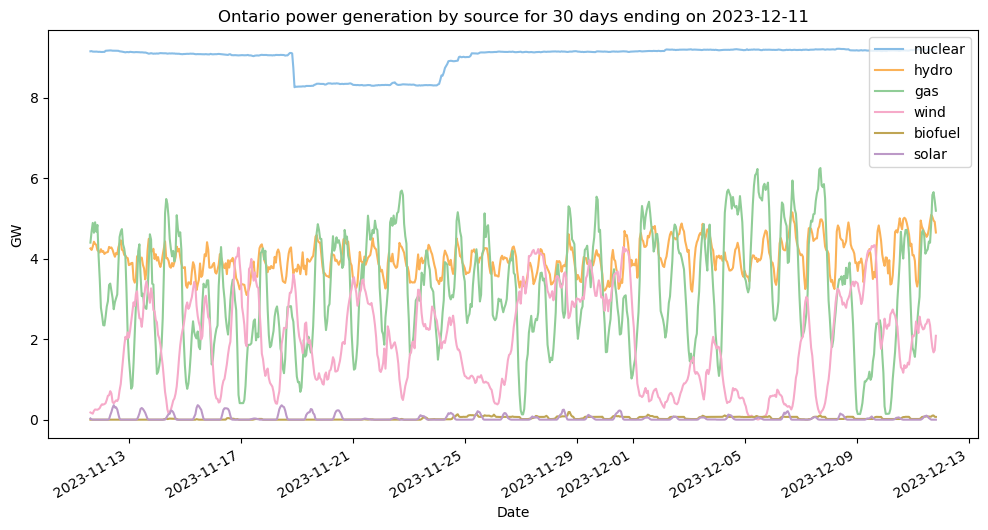

In [5]:
output_types = [col.replace(' (%)', '') for col in df_summary.columns if col.endswith(' (%)')]
output_cols = [f"{col} (MW)" for col in output_types]
(df_summary[output_cols].iloc[-30*24:] / 1e3).plot()
plt.ylabel('GW')
plt.xlabel('Date')
plt.title(f'Ontario power generation by source for 30 days ending on {df_summary.index[-1].date().isoformat()}')
plt.legend([col.replace(' (MW)', '') for col in output_cols])
plt.savefig(
    os.path.join("..", "images", "ontario_power_generation_by_source_30_day.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

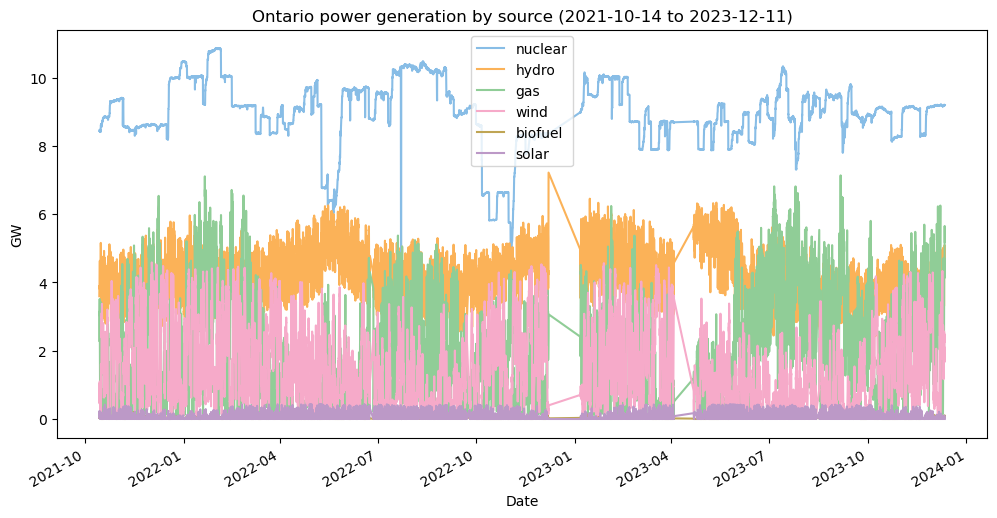

In [7]:
(df_summary[output_cols] / 1e3).plot()
plt.ylabel('GW')
plt.xlabel('Date')
plt.title(f'Ontario power generation by source ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.legend([col.replace(' (MW)', '') for col in output_cols])
plt.savefig(
    os.path.join("..", "images", "ontario_power_generation_by_source.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

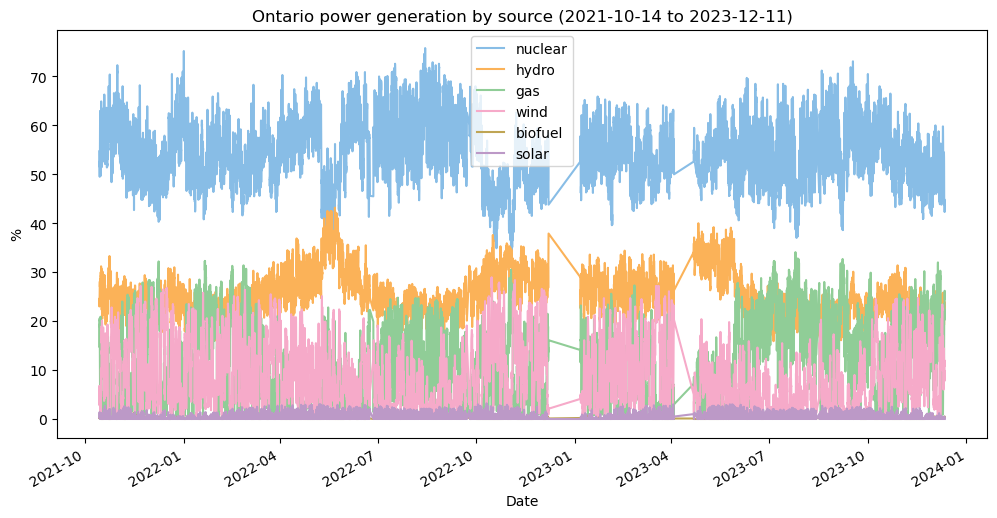

In [8]:
percentage_cols = [f"{col} (%)" for col in output_types]

df_summary[percentage_cols].plot()
plt.ylabel('%')
plt.xlabel('Date')
plt.title(f'Ontario power generation by source ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.legend([col.replace(' (%)', '') for col in percentage_cols])
plt.savefig(
    os.path.join("..", "images", "ontario_power_generation_by_source_percentage.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

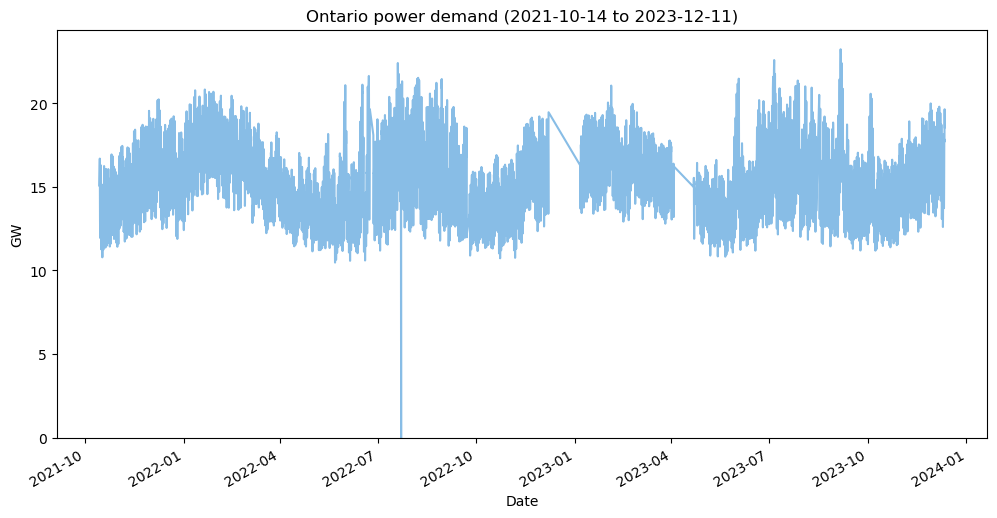

In [9]:
(df_summary['Ontario Demand (MW)'] / 1e3).plot()
plt.ylabel('GW')
plt.xlabel('Date')
plt.ylim([0, None])
plt.title(f'Ontario power demand ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.savefig(
    os.path.join("..", "images", "ontario_power_demand.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

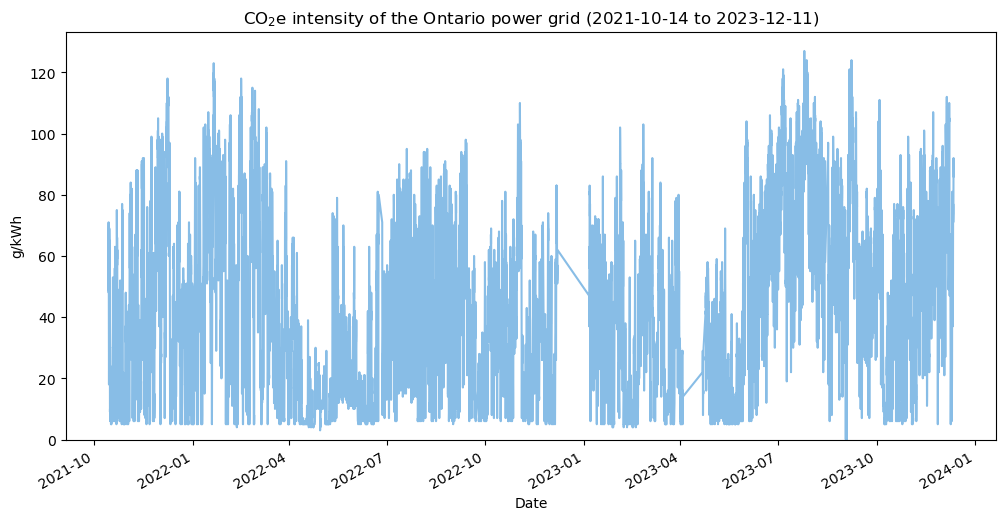

In [10]:
df_summary['CO2e Intensity (g/kWh)'].plot()
plt.ylabel('g/kWh')
plt.xlabel('Date')
plt.ylim([0, None])
plt.title(f'CO$_2$e intensity of the Ontario power grid ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.savefig(
    os.path.join("..", "images", "ontario_co2_intensity.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

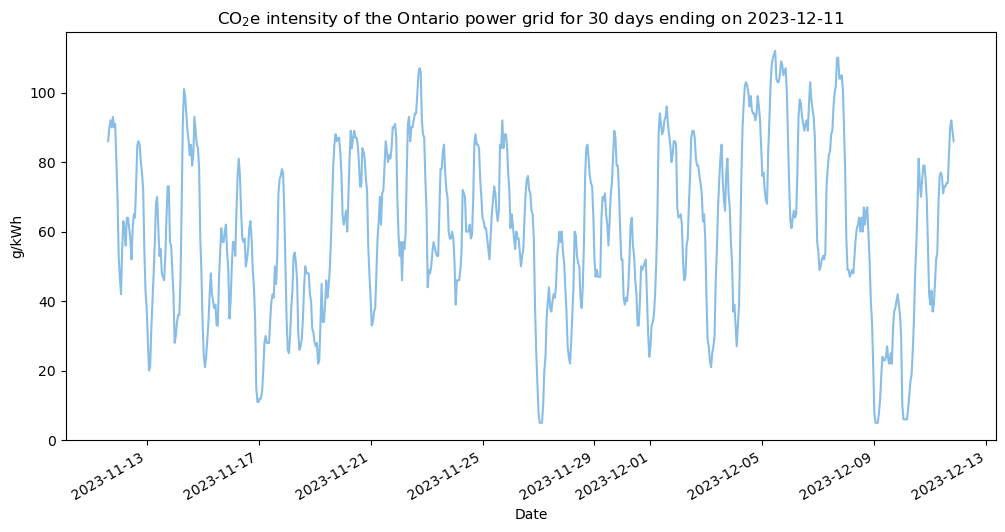

In [11]:
df_summary['CO2e Intensity (g/kWh)'].iloc[-24*30:].plot()
plt.ylabel('g/kWh')
plt.xlabel('Date')
plt.ylim([0, None])
plt.title(f'CO$_2$e intensity of the Ontario power grid for 30 days ending on {df_summary.index[-1].date().isoformat()}')
plt.savefig(
    os.path.join("..", "images", "ontario_co2_intensity_30_day.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

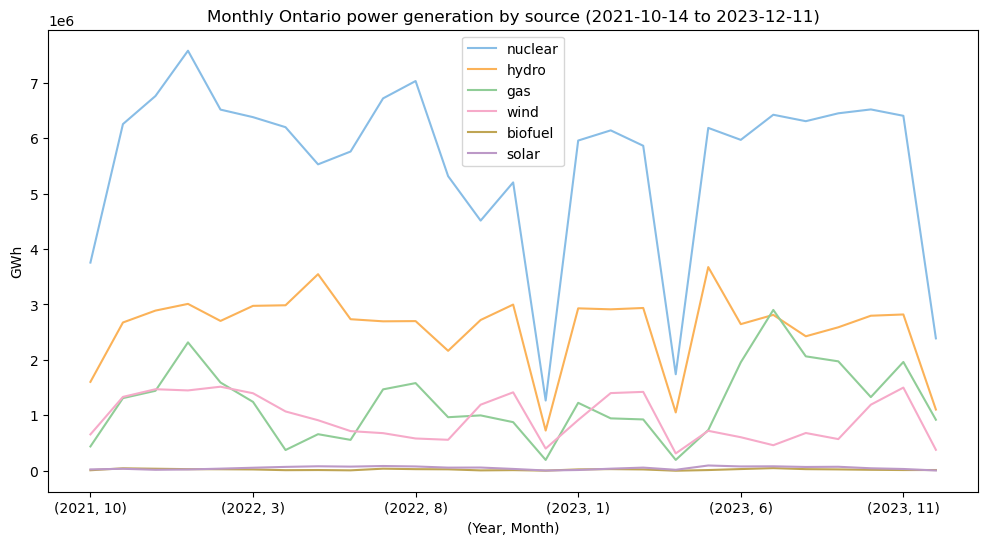

In [12]:
df_summary["month"] = df_summary.index.month
df_summary["year"] = df_summary.index.year
df_summary.groupby(["year", "month"]).sum()[output_cols].plot()
plt.ylabel('GWh')
plt.xlabel('(Year, Month)')
plt.title(f'Monthly Ontario power generation by source ({df_summary.index[0].date().isoformat()} to {df_summary.index[-1].date().isoformat()})')
plt.legend([col.replace(' (MW)', '') for col in output_cols])
plt.savefig(
    os.path.join("..", "images", "ontario_power_generation_by_source_monthly.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

In [33]:
df_gridwatch = pd.read_csv("https://raw.githubusercontent.com/ryanfobel/ontario-grid-data/main/data/clean/gridwatch.ca/hourly/summary.csv", index_col=0)
df_gridwatch.index = pd.to_datetime(df_gridwatch.index, utc=True).tz_convert("America/Toronto")
df_gridwatch = df_gridwatch.sort_index(ascending=True)
df_gridwatch.tail()

,Imports (MW),Exports (MW),Net Import/Exports (MW),Power Generated (MW),Ontario Demand (MW),Total Emissions (tonnes),CO2e Intensity (g/kWh),nuclear (%),hydro (%),gas (%),wind (%),biofuel (%),solar (%),nuclear (MW),hydro (MW),gas (MW),wind (MW),biofuel (MW),solar (MW)
2023-12-11 16:00:00-05:00,431.0,2632.0,2201.0,21266.0,19065.0,1742.0,82.0,43.2,23.9,23.0,9.6,0.4,0.0,9180.0,5090.0,4886.0,2034.0,76.0,0.0
2023-12-11 17:00:00-05:00,1080.0,3132.0,2052.0,21701.0,19649.0,1957.0,90.0,42.3,23.2,25.7,8.3,0.5,0.0,9186.0,5037.0,5583.0,1794.0,101.0,0.0
2023-12-11 18:00:00-05:00,545.0,2843.0,2298.0,21571.0,19273.0,1975.0,92.0,42.6,22.9,26.2,7.8,0.5,0.0,9194.0,4948.0,5653.0,1672.0,104.0,0.0
2023-12-11 19:00:00-05:00,404.0,2743.0,2339.0,21351.0,19012.0,1894.0,89.0,43.1,23.0,25.5,8.1,0.3,0.0,9193.0,4914.0,5447.0,1725.0,72.0,0.0
2023-12-11 20:00:00-05:00,9.0,2629.0,2620.0,21188.0,18568.0,1815.0,86.0,43.4,21.9,24.5,9.8,0.3,0.0,9194.0,4650.0,5191.0,2084.0,69.0,0.0


In [35]:
df_co2signal = pd.read_csv("https://raw.githubusercontent.com/ryanfobel/ontario-grid-data/main/data/clean/co2signal.com/CA-ON/hourly/output.csv", index_col=0)
df_co2signal.index = pd.to_datetime(df_co2signal.index, utc=True).tz_convert("America/Toronto")
df_co2signal = df_co2signal.sort_index(ascending=True)
df_co2signal.tail()

,data.carbonIntensity,data.fossilFuelPercentage,units.carbonIntensity
datetime,,,
2023-12-11 17:00:00-05:00,116,21.42,gCO2eq/kWh
2023-12-11 18:00:00-05:00,115,21.36,gCO2eq/kWh
2023-12-11 19:00:00-05:00,116,21.47,gCO2eq/kWh
2023-12-11 20:00:00-05:00,134,25.15,gCO2eq/kWh
2023-12-11 21:00:00-05:00,139,26.19,gCO2eq/kWh


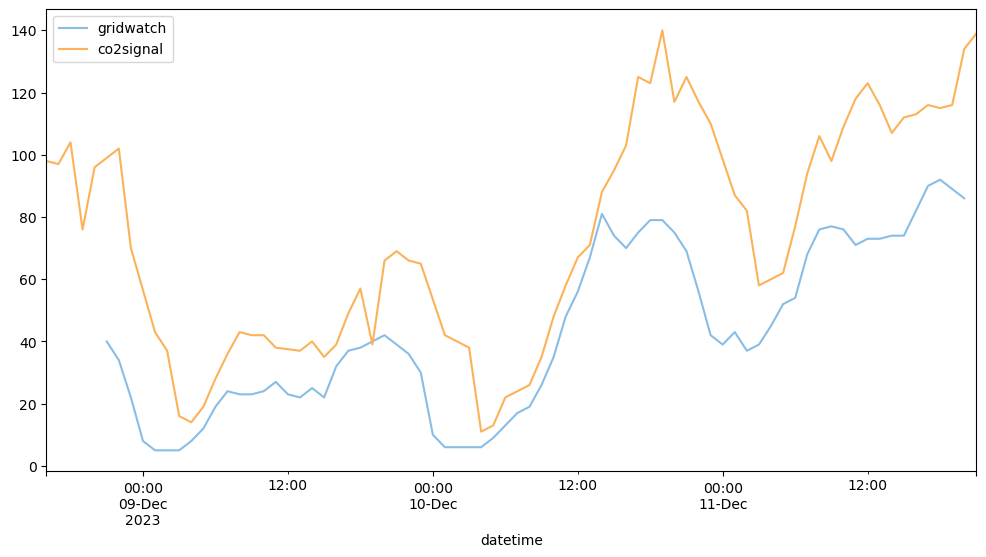

In [56]:
df_gridwatch.iloc[-24*3:]["CO2e Intensity (g/kWh)"].plot()
df_co2signal.iloc[-24*3:]["data.carbonIntensity"].plot()
plt.legend(["gridwatch", "co2signal"])

In [60]:
stage = "clean"
year = 2023
filepath = f"https://github.com/ryanfobel/ontario-grid-data/blob/main/data/{stage}/ieso.ca/hourly/output/{year}.csv?raw=true"
df = pd.read_csv(filepath, index_col=0, thousands=',', low_memory=False)

In [61]:
df

,ABKENORA,ADELAIDE,AGUASABON,ALEXANDER,AMARANTH,AMHERST ISLAND,APIROQUOIS,ARMOW,ARNPRIOR,ATIKOKAN-G1,...,WELLS,WEST LINCOLN NRWF,WESTWINDSOR,WHITBYCGS,WHITEDOG,WINDSOR AIRPORT SF,WOLFE ISLAND,YORKCGS-G1,YORKCGS-G2,ZURICH
2023-01-01 00:00:00-05:00,14,3,22,50,24,40,83,9,0,0,...,0,44,0,,66,0,50,0,0,22
2023-01-01 01:00:00-05:00,14,5,22,50,39,55,83,9,0,0,...,0,29,0,,66,0,78,0,0,30
2023-01-01 02:00:00-05:00,14,7,22,50,56,40,83,9,0,0,...,0,47,0,,66,0,75,0,0,18
2023-01-01 03:00:00-05:00,14,0,22,50,54,46,83,7,0,0,...,0,47,0,,66,0,71,0,0,9
2023-01-01 04:00:00-05:00,14,1,22,50,25,63,83,14,0,0,...,0,47,0,,54,0,94,0,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-10 19:00:00-05:00,12,9,1,41,45,12,87,90,1,53,...,0,32,0,,64,0,20,0,0,71
2023-12-10 20:00:00-05:00,12,20,0,41,36,8,86,94,0,53,...,0,43,0,,44,0,17,0,0,62
2023-12-10 21:00:00-05:00,12,31,0,41,40,4,86,77,36,53,...,0,44,0,,44,0,13,0,0,52
2023-12-10 22:00:00-05:00,12,32,0,41,54,5,86,95,1,13,...,0,31,0,,44,0,7,0,0,85
